In [38]:
import sklearn
import os
import sys
from Dataset.Prep import fnirs_utils
from Dataset.DataLoaders import hcpfNIRSLoader, hcpWorkingMemLoader
import numpy as np
import pandas as pd

In [39]:
x,y,subjectIDs = hcpfNIRSLoader.hcpfNIRSLoader(None,None,'HBR',None)
x = [j[:, :20] for j in x]
for i in x:
    if i.shape[1] != 20:
        print('Error: ', i.shape[1])
        print(i.shape)
    
x = np.array(x)
y = np.array(y)
subjectIDs = np.array(subjectIDs)
x = x[:,:,:35]
print(x.shape)
print(y.shape)
print(subjectIDs.shape)


All zeros:  [ 21  24  25  29  31  33  34  35  41  44  52  54  62  64  82  83  84  85
  89  90  91  92  93  94  95 101 107 110 113 114]
(562, 85, 20)
(562,)
(562,)


In [40]:
# x,y,subjectIDs = hcpWorkingMemLoader.hcpWorkingMemLoader('sphere', 'nback')

# for i in range(len(x)):
#     if x[i].shape[1] != 35 and x[i].shape[1] != 34:
#         print(x[i].shape[1])

# #x = np.array(x)
# y = np.array(y)
# subjectIDs = np.array(subjectIDs)


In [41]:
import numpy as np
from scipy.stats import entropy, linregress

def extract_features_multichannel(data):
    """
    Extract features from multichannel fNIRS (e.g., HbO) signal.

    Parameters:
    - data: np.ndarray, shape (n_channels, n_timepoints)

    Returns:
    - features: np.ndarray, shape (n_channels, n_features)
    """
    features = []

    for channel in data:
        # Time-domain features
        signal_mean = np.mean(channel)
        signal_peak = np.max(channel)
        signal_minimum = np.min(channel)
        signal_variance = np.var(channel)
        signal_median = np.median(channel)
        signal_peak_to_peak = signal_peak - signal_minimum
        signal_skewness = np.mean((channel - signal_mean)**3) / (np.std(channel)**3 + 1e-8)
        signal_kurtosis = np.mean((channel - signal_mean)**4) / (np.std(channel)**4 + 1e-8)
        
        # Slope (linear trend)
        slope, _, _, _, _ = linregress(np.arange(len(channel)), channel)
        
        # Energy
        signal_energy = np.sum(channel**2)

        # Entropy (after normalization)
        hist, _ = np.histogram(channel, bins=32, density=True)
        hist += 1e-8  # Avoid log(0)
        signal_entropy = entropy(hist)

        # Concatenate all features
        channel_features = [
            signal_mean, signal_peak, signal_minimum, signal_skewness,
            signal_kurtosis, signal_variance, signal_median, signal_peak_to_peak,
            slope, signal_energy, signal_entropy
        ]
        features.append(channel_features)

    return np.array(features)


In [42]:
features = []

for sample in x:  # x.shape: (n_samples, n_channels, n_timesteps)
    sample_features = []
    for channel in sample:  # shape: (n_timesteps,)
       
        channel_features = extract_features(channel)  # should return a 1D list or array
        sample_features.extend(channel_features)  # flatten across channels
    features.append(sample_features)  # shape: (n_samples, total_features)

features = np.array(features)
features = features.astype(np.float32)  # Convert to float32 for compatibility with TensorFlow
print(features.shape)  # should be (n_samples, n_channels * features_per_channel)
X_selected = features


(562, 680)


In [43]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

rfe = RFE(estimator=XGBClassifier(), n_features_to_select=200)
X_selected = rfe.fit_transform(features, y)



In [44]:
# # Use ANOVA test to select the top 200 features
# from sklearn.feature_selection import SelectKBest, f_classif

# # Fit the selector to the data
# selector = SelectKBest(score_func=f_classif, k=50)
# selector.fit(features, y)
# X_selected = selector.transform(features)
# # # Select features with p-value < 0.05
# # mask = selector.pvalues_ < 0.05
# # X_selected = features[:, mask]
# print(f"Original features shape: {features.shape}")
# print(f"Selected features shape: {X_selected.shape}")


In [45]:
from umap.umap_ import UMAP

import matplotlib.pyplot as plt

X_2d = UMAP().fit_transform(X_selected)


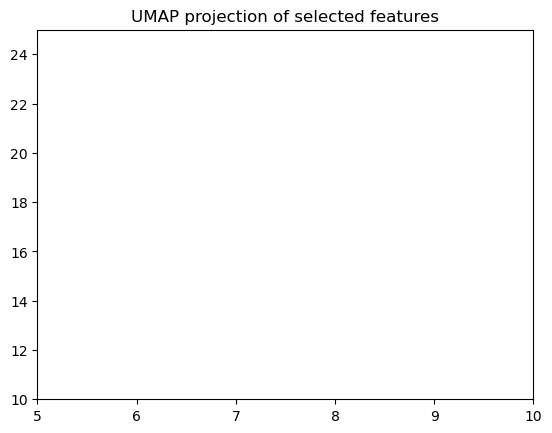

In [46]:
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("UMAP projection of selected features")
plt.xlim(5,10)
plt.ylim(10,25)
plt.show()


In [47]:
from sklearn.model_selection import cross_val_score, GroupKFold
from xgboost import XGBClassifier

clf = XGBClassifier()
cv = GroupKFold(n_splits=10)
# Use subject IDs as groups for cross-validation
groups = subjectIDs
# Perform cross-validation
# Note: cross_val_score will automatically handle the reshaping of y if needed
scores = cross_val_score(clf, X_selected, y, cv=cv, groups=groups, scoring='accuracy')

print(f"Mean accuracy: {scores.mean():.2f}")


Mean accuracy: 0.63


In [52]:
# Grid search
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],              # Lower = less overfit
    'classifier__early_stopping_rounds': [10, 20],    # Early stopping
    'classifier__learning_rate': [0.01, 0.05],    # Lower + more trees = better generalization
    'classifier__subsample': [0.6, 0.8],          # Use subsets of data
    'classifier__colsample_bytree': [0.6, 0.8],   # Use subsets of features
    'classifier__reg_alpha': [0, 0.1, 1],         # L1 regularization
    'classifier__reg_lambda': [1, 5, 10]          # L2 regularization
}

# Create a pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(eval_metric='mlogloss'))
])

# Create a GroupKFold object
cv = GroupKFold(n_splits=10)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(accuracy_score),
    cv=cv,
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_selected, y, groups=groups)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Save the best model
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')


Fitting 10 folds for each of 576 candidates, totalling 5760 fits


ValueError: 
All the 5760 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5760 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\training.py", line 184, in train
    if cb_container.after_iteration(bst, i, dtrain, evals):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\callback.py", line 267, in after_iteration
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\callback.py", line 267, in <genexpr>
    ret = any(c.after_iteration(model, epoch, self.history) for c in self.callbacks)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Alex\anaconda3\envs\bolt\Lib\site-packages\xgboost\callback.py", line 463, in after_iteration
    raise ValueError(msg)
ValueError: Must have at least 1 validation dataset for early stopping.


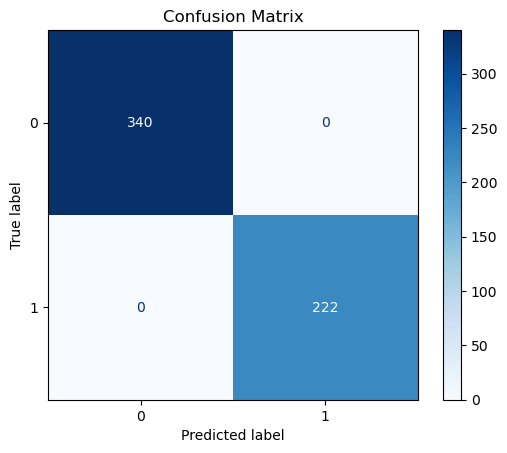

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       340
           1       1.00      1.00      1.00       222

    accuracy                           1.00       562
   macro avg       1.00      1.00      1.00       562
weighted avg       1.00      1.00      1.00       562



In [49]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = grid_search.predict(X_selected)
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# Print classification report
print(classification_report(y, y_pred))
